# Домашнее задание №1: линейная регрессия и векторное дифференцирование (10 баллов) - Маханова_НН_Вариант 1.

* Максимальное количество баллов за задания в ноутбуке - 11, но больше 10 оценка не ставится, поэтому для получения максимальной оценки можно сделать не все задания.

* Некоторые задания будут по вариантам (всего 4 варианта). Чтобы выяснить свой вариант, посчитайте количество букв в своей фамилии, возьмете остаток от деления на 4 и прибавьте 1.

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

## Многомерная линейная регрессия из sklearn

Применим многомерную регрессию из sklearn для стандартного датасета

In [2]:
X, y = make_regression(n_samples = 10000, n_features=5)
print(X.shape, y.shape)

(10000, 5) (10000,)


У нас 10000 объектов и 100 признаков. Для начала решим задачу аналитически "из коробки".

In [3]:
reg = LinearRegression().fit(X, y)
print(mean_squared_error(y, reg.predict(X)))
MSE = mean_squared_error(y, reg.predict(X))
#reg.coef_

1.6540389616212067e-26


Теперь попробуем обучить линейную регрессию методом градиентного спуска "из коробки"

In [4]:
reg = SGDRegressor(alpha=0.00000001).fit(X, y)
MSE_descent = mean_squared_error(y, reg.predict(X))
print(mean_squared_error(y, reg.predict(X)))
#reg.coef_

1.270875995655589e-12


***Задание 1 (0.5 балла).*** Объясните, чем вызвано различие двух полученных значений метрики?

<font color='blue'>Аналитическое решение даёт ответ с помощью минимизации отклонений модели от данных, а градиентный спуск итеративно сходится к оптимальному решению, поэтому может давать другие результаты в зависимости от количества и величины шагов. Также градиентный спуск может по разным причинам перестать сходиться, из-за чего разница будет ещё больше.</font>

***Задание 2 (0.5 балла).*** Подберите гиперпараметры в методе градиентного спуска так, чтобы значение MSE было близко к значению MSE, полученному при обучении LinearRegression.

С помощью данной функции получаем модуль разницы между MSE LinearRegression() и градиентным спуском с данной альфой

In [5]:
def get_difference(alpha):
    reg = SGDRegressor(alpha = alpha).fit(X, y)
    return (abs(MSE - mean_squared_error(y, reg.predict(X))))

Получаем список разниц с разными альфа в диапазоне 50 шагов влево и 20 вправо от изначального значения

In [6]:
a_initial = 0.00000001
a_step = a_initial / 100
a_start = a_initial - a_step * 50
a_end = a_initial + a_step * 20
alphas = np.arange(a_start, a_end, a_step)

MSE_diff = []
for alpha in alphas:
    MSE_diff.append(get_difference(alpha))

Строим график, чтобы посмотреть изменение разницы в зависимости от выбранной альфа. На графике видно, что при уменьшении альфа разница уменьшается, поэтому лучшая альфа в выборке - наименьшая. Линия - изначальное значение альфа.

Text(0, 0.5, 'MSE diff')

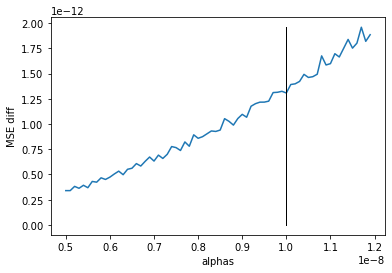

In [7]:
plt.plot(alphas, MSE_diff)
plt.plot([a_initial, a_initial], [0, max(MSE_diff)], 'k-', lw=1)
plt.xlabel('alphas')
plt.ylabel('MSE diff')

In [8]:
array = np.array([alphas, MSE_diff])

best_alpha_index = array[1].argmin()
best_alpha = array[0, best_alpha_index]

print("Ответ: альфа равная " + str(best_alpha))

Ответ: альфа равная 5e-09


## Ваша многомерная линейная регрессия

***Задание 3 (5 баллов)***. Напишите собственную многомерную линейную регрессию, оптимизирующую MSE методом *градиентного спуска*. Для этого используйте шаблонный класс. 

Критерий остановки: либо норма разности весов на текущей и предыдущей итерациях меньше определенного значения (первый и третий варианты), либо модуль разности функционалов качества (MSE) на текущей и предыдущей итерациях меньше определенного значения (второй и четвертый варианты). Также предлагается завершать обучение в любом случае, если было произведено слишком много итераций.

***Задание 4 (2 балла)***. Добавьте l1 (первый и второй варианты) или l2 (третий и четвертый варианты) регуляризацию. 

In [17]:
class MyLinearRegression(object):
    def __init__(self, alpha=0.0001, l_ratio=0.001, tol=0.001, max_iter=1000):
        self.alpha = alpha
        self.l_ratio = l_ratio
        self.tol = tol
        self.max_iter = max_iter
             
    def fit(self, X, y):
        # Проверяем на одномерность датасет
        if (len(X.shape) > 1):
            self.beta = np.ones(X.shape[1])
        else:
            self.beta = 0
        self.c = 0
        
        for i in range(self.max_iter):
            loss = (np.dot(X, self.beta) + self.c) - y
            
            # Вычисляем градиент с учётом l1 регуляризации
            beta_gradient = X.T@loss / X.shape[0] + self.l_ratio*np.linalg.norm(self.beta)
            c_gradient = loss.sum() / X.shape[0]

            new_beta = self.beta - self.alpha * beta_gradient
            
            # Проверяем критерий остановки
            norm = np.linalg.norm(self.beta - new_beta)
            if (norm < self.tol):
                break
            
            # Назначаем новые значения параметров
            self.beta = new_beta
            self.c = self.c - c_gradient
        
    def predict(self, X):
        prediction = np.dot(X, self.beta) + self.c
        
        return prediction

In [20]:
my_reg = MyLinearRegression(max_iter = 1000000, tol = 0.0000001, l_ratio = 0.000001)
my_reg.fit(X, y)

print(mean_squared_error(y, my_reg.predict(X)))
assert mean_squared_error(y, my_reg.predict(X)) < 1e-3
print('You are amazing! Great work!')

1.414364915423616e-06
You are amazing! Great work!


***Задание 5 (1 балл)***. Обучите линейную регрессию из коробки

* с l1-регуляризацией (from sklearn.linear_model import Lasso, **первый и второй вариант**) или с l2-регуляризацией (from sklearn.linear_model import Ridge, **третий и четвертый вариант**)
* со значением параметра регуляризации **0.1 - для первого и третьего варианта, 0.01 - для второго и четвертого варианта**. 

Обучите вашу линейную регрессию с тем же значением параметра регуляризации и сравните результаты. Сделайте выводы.

In [11]:
lasso = Lasso(alpha = 0.1)
lasso.fit(X, y)

my_regression = MyLinearRegression(max_iter = 10000000, tol = 0.0000001, l_ratio = 0.1)
my_regression.fit(X, y)

MSE_sklearn = mean_squared_error(y, lasso.predict(X))
MSE_my = mean_squared_error(y, my_regression.predict(X))

print(MSE_sklearn)
print(MSE_my)

0.049686209767317
501.29346692268047


<font color='blue'>Вывод: Лучше использовать из коробки)<font>

***Задание 6* (1 балл).***
Пусть $P, Q \in \mathbb{R}^{n\times n}$. Найдите $\nabla_Q tr(PQ)$

<font color='blue'>Ответ: матрица P транспонированная

<font color='blue'>Объяснение: tr(XY) равен двойной сумме Xij * Yji, которая после дифференцирования по матрице Y даёт матрицу той же размерности, в которой оставляет в лишь элементы матрицы X, но в транспонированном порядке.<font>

***Задание 7* (1 балл).***
Пусть $x, y \in \mathbb{R}^{n}, M \in \mathbb{R}^{n\times n}$. Найдите $\nabla_M x^T M y$

<font color='blue'>Ответ: X*Y^T

Решения заданий 6 и 7 можно написать на листочке и отправить в anytask вместе с заполненным ноутбуком.